## Introduction
In this notebook, we explore a novel approach to data preprocessing and modeling.  The one-dimensional mass spectrometry data is transformed into two-dimensional images using a helix matrix transformation. A 2D Convolutional Neural Network (2D CNN) is then trained on these transformed images. This section investigates whether this visual transformation can provide new, discriminative features for predicting drug resistance, and it compares the performance of the 2D CNN with the 1D CNN and classic machine learning models.

### Data Preparation

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import cv2
from typing import Tuple, List
import random
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')

Load Dataset

In [2]:
if os.path.exists('../data/e_coli_driams_a_bin3_2000_20000Da.csv'):
    df = pd.read_csv('../data/e_coli_driams_a_bin3_2000_20000Da.csv')
else:
    df = pd.read_csv('https://media.githubusercontent.com/media/xlopez-ml/DL-AMR/master/datasets/driams_a/s_aureus_driams_a_bin3_2000_20000Da.csv')

In [3]:
df.head()

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19991,19994,19997,code,species,Oxacillin,Clindamycin,Ceftriaxone,Ciprofloxacin,Fusidic acid
0,951.428571,826.125000,944.857143,898.428571,1007.714286,936.000000,828.571429,812.000000,782.714286,741.625000,...,35.5,20.5,27.342857,029f0abf-1664-424f-88cb-11c9c8af2b11,Staphylococcus aureus,0.0,0.0,0.0,0.0,1.0
1,784.714286,701.125000,681.571429,762.142857,737.571429,733.000000,735.857143,659.571429,802.714286,554.375000,...,30.0,40.5,34.695238,08149af1-10f5-4f02-81d8-3d46d66d4a7a,Staphylococcus aureus,0.0,0.0,0.0,0.0,0.0
2,50.875000,89.142857,56.142857,151.285714,132.714286,110.428571,47.285714,63.428571,100.375000,52.142857,...,2.5,30.5,11.288462,08fe3876-ecee-4ddc-9aa9-a84f605757f7,Staphylococcus aureus,0.0,0.0,0.0,0.0,0.0
3,843.285714,816.500000,734.428571,1027.142857,979.428571,875.571429,912.142857,714.428571,945.428571,886.500000,...,15.5,8.0,20.057143,0a9fdd4b-7180-47c0-849e-cb32d46da94c,Staphylococcus aureus,0.0,0.0,0.0,0.0,0.0
4,307.857143,295.000000,246.714286,181.571429,258.000000,318.714286,295.714286,300.857143,278.142857,256.125000,...,25.5,32.0,24.990476,0d82f4c4-473c-49d8-8c85-e3e36e96d047,Staphylococcus aureus,1.0,0.0,1.0,1.0,0.0


In [4]:
antibiotics = df.columns[-5:].to_list()
antibiotics

['Oxacillin', 'Clindamycin', 'Ceftriaxone', 'Ciprofloxacin', 'Fusidic acid']

### Create Dataset

In [5]:
class MALDITOFDataset(Dataset):
    
    def __init__(self, spectra: np.ndarray, labels: np.ndarray, target_size: Tuple[int, int] = (64, 64)):
        self.spectra = spectra
        self.labels = labels
        self.target_size = target_size
        
    def __len__(self):
        return len(self.spectra)
    
    def __getitem__(self, idx):
        spectrum = self.spectra[idx]
        label = [self.labels[idx]]
        
        # Apply transformations
        helix_matrix = self.helix_matrix_transform(spectrum)
        binary_image = self.image_binarization(helix_matrix)
        resized_image = self.resize_image(binary_image, self.target_size)
        
        # Convert to tensor and add channel dimension
        image_tensor = torch.FloatTensor(resized_image).unsqueeze(0)  # Add channel dim
        label_tensor = torch.LongTensor(label)
        
        return image_tensor, label_tensor.squeeze()
    
    def helix_matrix_transform(self, spectrum_1d: np.ndarray) -> np.ndarray:
        """
        Transform 1D spectrum to 2D using helix matrix transformation
        Creates a spiral-like pattern filling a square matrix
        """
        n = len(spectrum_1d)
        # Calculate square matrix size (find smallest square that can fit all data)
        side_length = int(np.ceil(np.sqrt(n)))
        
        # Create empty matrix
        matrix = np.zeros((side_length, side_length))
        
        # Fill matrix in spiral pattern (helix-like)
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # right, down, left, up
        direction_idx = 0
        row, col = 0, 0
        
        for i in range(min(n, side_length * side_length)):
            matrix[row, col] = spectrum_1d[i]
            
            # Calculate next position
            dr, dc = directions[direction_idx]
            next_row, next_col = row + dr, col + dc
            
            # Check if we need to turn (hit boundary or filled cell)
            if (next_row < 0 or next_row >= side_length or 
                next_col < 0 or next_col >= side_length or 
                matrix[next_row, next_col] != 0):
                direction_idx = (direction_idx + 1) % 4
                dr, dc = directions[direction_idx]
                next_row, next_col = row + dr, col + dc
            
            row, col = next_row, next_col
        
        return matrix
    
    def image_binarization(self, matrix: np.ndarray, threshold_method: str = 'otsu') -> np.ndarray:
        """
        Convert grayscale matrix to binary image
        """
        # Normalize to 0-255 range
        normalized = ((matrix - matrix.min()) / (matrix.max() - matrix.min()) * 255).astype(np.uint8)
        
        if threshold_method == 'otsu':
            # Use Otsu's method for automatic thresholding
            _, binary = cv2.threshold(normalized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        else:
            # Use mean as threshold
            threshold = np.mean(normalized)
            binary = (normalized > threshold).astype(np.uint8) * 255
        
        return binary.astype(np.float32) / 255.0  # Normalize to 0-1
    
    def resize_image(self, image: np.ndarray, target_size: Tuple[int, int]) -> np.ndarray:
        """
        Resize image to target size using bilinear interpolation
        """
        resized = cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)
        return resized

In [6]:
antibiotic = antibiotics[2]
max_length = 6000
antibiotic_df = df.iloc[:, :max_length].join(df[antibiotic])
antibiotic_df = antibiotic_df.dropna(how='any').reset_index(drop=True)

spectra = antibiotic_df.iloc[:, 0:77*77].values
labels = antibiotic_df.iloc[:, 6000].values

X_train, X_test, y_train, y_test = train_test_split(
    spectra, labels, test_size=0.2, random_state=42, stratify=labels
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify=y_train
)

In [7]:
target_size = (32, 32)
train_dataset = MALDITOFDataset(X_train, y_train, target_size)
val_dataset = MALDITOFDataset(X_val, y_val, target_size)
test_dataset = MALDITOFDataset(X_test, y_test, target_size)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Fit Model

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [9]:
class CNN2D(nn.Module):
    """
    2D CNN model for antimicrobial resistance classification
    """
    
    def __init__(self, input_size: Tuple[int, int] = (64, 64), num_classes: int = 2):
        super(CNN2D, self).__init__()
        
        self.features = nn.Sequential(
            # First convolutional block
            nn.Conv2d(1, 32, kernel_size=5, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Second convolutional block
            nn.Conv2d(32, 64, kernel_size=5, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Third convolutional block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Fourth convolutional block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        
        # Calculate flattened size
        self.flattened_size = self._get_flattened_size(input_size)
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.flattened_size, 512),
            nn.ReLU(inplace=True),
            # nn.Dropout(0.5),
            # nn.Linear(512, 256),
            # nn.ReLU(inplace=True),
            nn.Linear(512, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, num_classes)
        )
    
    def _get_flattened_size(self, input_size):
        """Calculate the size of flattened features"""
        with torch.no_grad():
            x = torch.zeros(1, 1, *input_size)
            x = self.features(x)
            return x.numel()
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

In [10]:
model = CNN2D(input_size=target_size)
model.to(device)

CNN2D(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine

In [11]:
class EarlyStopping:
    def __init__(self, model, patience=5, delta=0.0001, path='../checkpoints/best_model.pt', verbose=True):
        self.model = model
        self.patience = patience
        self.delta = delta
        self.path = path
        self.verbose = verbose
        self.best_loss = None
        self.no_improvement_count = 0

    def check_early_stop(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.no_improvement_count = 0
            # Save checkpoint if improvement observed
            torch.save(self.model.state_dict(), self.path)
            if self.verbose:
                print(f"Model improved; checkpoint saved at loss {val_loss:.4f}")
        else:
            self.no_improvement_count += 1
            if self.no_improvement_count >= self.patience:
                print("Early stopping triggered.")
                return True  # Signal to stop training
        return False

In [12]:
learning_rate = 1e-3# - 1e-6
num_epochs = 50

early_stopper = EarlyStopping(model=model, patience=5, path='./model4.pt', delta=1e-4, verbose=0)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

In [13]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    # Validation phase
    model.eval()

    running_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    
    val_loss = running_loss / len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    scheduler.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}')

    # if early_stopper.check_early_stop(val_loss):
    #     print(f"Stopping training at epoch {epoch+1}")
    #     break

Epoch [1/50], Loss: 0.51814, Val Loss: 0.49428


Epoch [2/50], Loss: 0.49809, Val Loss: 0.49611


Epoch [3/50], Loss: 0.48564, Val Loss: 0.47342


Epoch [4/50], Loss: 0.46838, Val Loss: 0.47113


Epoch [5/50], Loss: 0.45763, Val Loss: 0.45946


Epoch [6/50], Loss: 0.44056, Val Loss: 0.45816


Epoch [7/50], Loss: 0.42280, Val Loss: 0.51079


Epoch [8/50], Loss: 0.41893, Val Loss: 0.44514


Epoch [9/50], Loss: 0.40278, Val Loss: 0.44116


Epoch [10/50], Loss: 0.38568, Val Loss: 0.46750


Epoch [11/50], Loss: 0.38593, Val Loss: 0.44085


Epoch [12/50], Loss: 0.34898, Val Loss: 0.41697


Epoch [13/50], Loss: 0.33494, Val Loss: 0.58847


Epoch [14/50], Loss: 0.32916, Val Loss: 0.41053


Epoch [15/50], Loss: 0.29254, Val Loss: 0.68906


Epoch [16/50], Loss: 0.29604, Val Loss: 0.59250


Epoch [17/50], Loss: 0.27547, Val Loss: 0.56887


Epoch [18/50], Loss: 0.24675, Val Loss: 0.59367


Epoch [19/50], Loss: 0.22906, Val Loss: 0.53722


Epoch [20/50], Loss: 0.21116, Val Loss: 0.57021


Epoch [21/50], Loss: 0.17287, Val Loss: 0.63890


Epoch [22/50], Loss: 0.14307, Val Loss: 0.61892


Epoch [23/50], Loss: 0.14999, Val Loss: 0.60178


Epoch [24/50], Loss: 0.12978, Val Loss: 1.11013


Epoch [25/50], Loss: 0.13272, Val Loss: 0.65273


Epoch [26/50], Loss: 0.11311, Val Loss: 0.74781


Epoch [27/50], Loss: 0.09672, Val Loss: 0.71872


Epoch [28/50], Loss: 0.10579, Val Loss: 0.77443


Epoch [29/50], Loss: 0.10621, Val Loss: 0.85215


Epoch [30/50], Loss: 0.11382, Val Loss: 0.94337


Epoch [31/50], Loss: 0.08891, Val Loss: 0.96742


Epoch [32/50], Loss: 0.08716, Val Loss: 0.80998


Epoch [33/50], Loss: 0.06915, Val Loss: 1.52058


Epoch [34/50], Loss: 0.08849, Val Loss: 1.21537


Epoch [35/50], Loss: 0.07429, Val Loss: 0.89031


Epoch [36/50], Loss: 0.06241, Val Loss: 1.06912


Epoch [37/50], Loss: 0.09949, Val Loss: 0.80411


Epoch [38/50], Loss: 0.06287, Val Loss: 1.15107


Epoch [39/50], Loss: 0.06214, Val Loss: 1.32693


Epoch [40/50], Loss: 0.06295, Val Loss: 1.27381


Epoch [41/50], Loss: 0.03497, Val Loss: 1.25987


Epoch [42/50], Loss: 0.02892, Val Loss: 1.35902


Epoch [43/50], Loss: 0.02752, Val Loss: 1.38847


Epoch [44/50], Loss: 0.03668, Val Loss: 1.44127


Epoch [45/50], Loss: 0.03225, Val Loss: 1.42933


Epoch [46/50], Loss: 0.03138, Val Loss: 1.53653


Epoch [47/50], Loss: 0.02298, Val Loss: 1.65862


Epoch [48/50], Loss: 0.02344, Val Loss: 1.75679


Epoch [49/50], Loss: 0.03085, Val Loss: 1.57643


Epoch [50/50], Loss: 0.03003, Val Loss: 1.85216


### Model Evaluation

In [14]:
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        # _, labels = torch.max(labels, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [15]:
print(classification_report(y_pred=all_preds, y_true=all_labels))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89       586
           1       0.55      0.31      0.40       142

    accuracy                           0.82       728
   macro avg       0.70      0.62      0.64       728
weighted avg       0.79      0.82      0.79       728



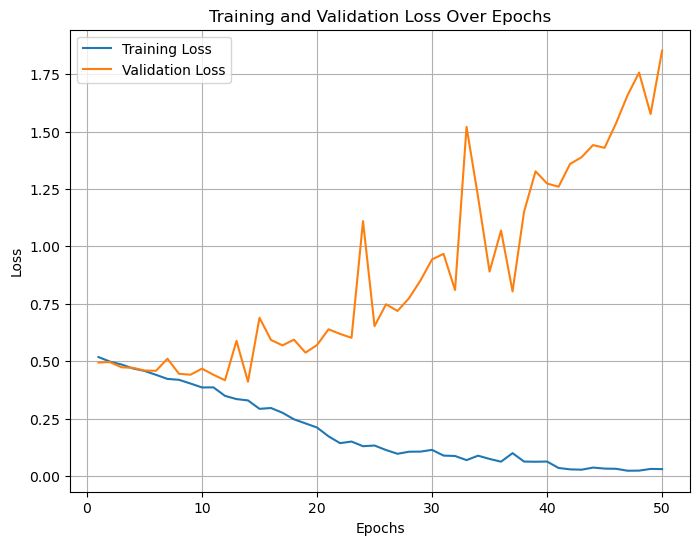

In [16]:
epochs = range(1, len(train_losses) + 1)
    
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

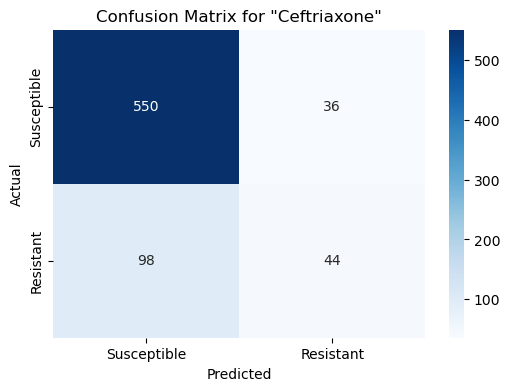

In [17]:
cm = confusion_matrix(all_labels, all_preds)

target_names = ['Susceptible', 'Resistant']
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f'Confusion Matrix for "{antibiotic}"')
plt.show()

In [20]:
from sklearn.metrics import (
    average_precision_score,
    roc_auc_score,
)

auc = roc_auc_score(all_labels, all_preds)
aucpr = average_precision_score(all_labels, all_preds)
print(f"AUROC: {auc:0.4f},\nAUPRC: {aucpr:0.4f}")

AUROC: 0.6242,
AUPRC: 0.3050
